<a href="https://colab.research.google.com/github/fabricio-franca/Data-Science/blob/main/regressao-arvoredecisao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
# Importação das bibliotecas principais
import pandas as pd
import numpy as np

# Bibliotecas de pré-processamento e modelagem
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Carregar o dataset
df = pd.read_csv("autos.csv", encoding='latin-1')  # 'latin-1' usado por ser dataset europeu

# Copiar o dataset original para preservar dados brutos
df_clean = df.copy()

display(df.head())

,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
0,2016-03-24 11:52:17,Golf_3_1.6,privat,Angebot,480,test,NaN,1993,manuell,0,golf,150000,0,benzin,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,A5_Sportback_2.7_Tdi,privat,Angebot,18300,test,coupe,2011,manuell,190,NaN,125000,5,diesel,audi,ja,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,"Jeep_Grand_Cherokee_""Overland""",privat,Angebot,9800,test,suv,2004,automatik,163,grand,125000,8,diesel,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,GOLF_4_1_4__3TÜRER,privat,Angebot,1500,test,kleinwagen,2001,manuell,75,golf,150000,6,benzin,volkswagen,nein,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,Skoda_Fabia_1.4_TDI_PD_Classic,privat,Angebot,3600,test,kleinwagen,2008,manuell,69,fabia,90000,7,diesel,skoda,nein,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [40]:
# Informações gerais: colunas, tipos, nulos
df.info()

# Verificar quantidade de valores nulos por coluna
print(df.isnull().sum().sort_values(ascending=False))

# Verificar colunas com valores únicos (constantes)
for col in df.columns:
    if df[col].nunique() == 1:
        print(f"- {col} (valor único: {df[col].unique()[0]})")

# Verificar estatísticas descritivas para variáveis numéricas
display(df.describe().transpose())

# Ver distribuição do preço (alvo)
print("\n Distribuição da variável 'price':")
print(df['price'].describe())
print("\n Faixas de preço:")
print(pd.cut(df['price'], bins=[0, 500, 1000, 5000, 10000, 50000, 100000]).value_counts().sort_index())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371528 entries, 0 to 371527
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   dateCrawled          371528 non-null  object
 1   name                 371528 non-null  object
 2   seller               371528 non-null  object
 3   offerType            371528 non-null  object
 4   price                371528 non-null  int64 
 5   abtest               371528 non-null  object
 6   vehicleType          333659 non-null  object
 7   yearOfRegistration   371528 non-null  int64 
 8   gearbox              351319 non-null  object
 9   powerPS              371528 non-null  int64 
 10  model                351044 non-null  object
 11  kilometer            371528 non-null  int64 
 12  monthOfRegistration  371528 non-null  int64 
 13  fuelType             338142 non-null  object
 14  brand                371528 non-null  object
 15  notRepairedDamage    299468 non-nu

,count,mean,std,min,25%,50%,75%,max
price,371528.0,17295.141865,3.587954e+06,0.0,1150.0,2950.0,7200.0,2.147484e+09
yearOfRegistration,371528.0,2004.577997,9.286660e+01,1000.0,1999.0,2003.0,2008.0,9.999000e+03
powerPS,371528.0,115.549477,1.921396e+02,0.0,70.0,105.0,150.0,2.000000e+04
kilometer,371528.0,125618.688228,4.011234e+04,5000.0,125000.0,150000.0,150000.0,1.500000e+05
monthOfRegistration,371528.0,5.734445,3.712412e+00,0.0,3.0,6.0,9.0,1.200000e+01
nrOfPictures,371528.0,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00
postalCode,371528.0,50820.667640,2.579908e+04,1067.0,30459.0,49610.0,71546.0,9.999800e+04



 Distribuição da variável 'price':
count    3.715280e+05
mean     1.729514e+04
std      3.587954e+06
min      0.000000e+00
25%      1.150000e+03
50%      2.950000e+03
75%      7.200000e+03
max      2.147484e+09
Name: price, dtype: float64

 Faixas de preço:
price
(0, 500]            30954
(500, 1000]         46252
(1000, 5000]       156501
(5000, 10000]       66641
(10000, 50000]      58840
(50000, 100000]      1159
Name: count, dtype: int64


# 1. Qualidade dos Dados
O dataset contém 371.528 registros e 20 colunas, sendo 13 categóricas e 7 numéricas.

Algumas colunas apresentam grande quantidade de valores ausentes, como:

-notRepairedDamage (72.060 valores nulos, ~19%)

-vehicleType (37.869 nulos, ~10%)

-fuelType (33.386 nulos, ~9%)

-model (20.484 nulos, ~5%)

-gearbox (20.209 nulos, ~5%)

A coluna nrOfPictures possui valor constante igual a 0 para todos os registros, indicando que não carrega informação útil e pode ser removida diretamente.

Outras colunas como seller e offerType possuem baixa variabilidade e devem ser avaliadas para exclusão, já que tendem a ser irrelevantes para a regressão.

# 2. Análise de Variáveis Numéricas


##price (variável alvo)
Distribuição altamente assimétrica, com média (€17.295) muito superior à mediana (€2.950), indicando a presença de outliers extremos.

O desvio padrão é enorme (3,5 milhões), e o valor máximo (2,1 bilhões) é completamente irreal, reforçando a necessidade de um tratamento rigoroso de outliers.

A maioria dos veículos (cerca de 81%) está na faixa de €500 a €10.000, o que sugere que a modelagem deve se concentrar nessa faixa de mercado para melhor performance.

##powerPS (potência)


A potência média está em torno de 115 cv, o que é coerente com veículos populares.

No entanto, há valores extremos até 20.000 cv, o que é totalmente fora da realidade para veículos comuns, indicando erro de entrada ou outliers.


##kilometer

Distribuição mais consistente, com a maioria dos veículos próximos de 125.000 a 150.000 km.

Valor máximo de 150.000 pode indicar um limite superior na coleta dos dados.

##yearOfRegistration

Embora a média indique um ano típico de registro em 2004, há registros com ano 1000 e até 9999, o que são valores claramente inválidos e precisam ser filtrados.

Isso pode distorcer totalmente o aprendizado do modelo se não for tratado.

##monthOfRegistration
A mediana é 6, e o intervalo vai corretamente de 0 a 12.

No entanto, valores como 0 devem ser tratados como inválidos ou desconhecidos.

A análise mostra que o dataset possui muitos dados úteis, porém altamente ruidosos. Outliers, valores ausentes e entradas com valores inválidos são predominantes e precisam ser cuidadosamente tratados antes de qualquer modelagem. Algumas colunas são irrelevantes e podem ser descartadas para reduzir dimensionalidade. A distribuição dos preços reforça a necessidade de normalização ou transformação da variável-alvo, e a aplicação de técnicas robustas contra outliers, como o uso de Random Forest (como estamos fazendo), é bem adequada neste cenário.



# ------------------------------
# PRÉ-PROCESSAMENTO
# ------------------------------

In [41]:
# Remover colunas que não contribuem diretamente para a previsão do preço após análise fundamentalista
columns_to_drop = ['name', 'dateCrawled', 'dateCreated', 'lastSeen', 'nrOfPictures', 'postalCode']
df_clean.drop(columns=columns_to_drop, axis=1, inplace=True)

# Remover registros com preço inválido (preço zero ou muito baixo)
df_clean = df_clean[df_clean['price'] >= 100]

# Manter apenas veículos com ano de registro dentro de um intervalo razoável (1950 a 2019)
df_clean = df_clean[(df_clean['yearOfRegistration'] >= 1950) & (df_clean['yearOfRegistration'] <= 2019)]

# Remover veículos com potência (powerPS) fora de um intervalo considerado normal (10 a 500)
df_clean = df_clean[(df_clean['powerPS'] >= 10) & (df_clean['powerPS'] <= 500)]

# Tratar valores ausentes (NaN) nas colunas categóricas substituindo por 'missing'
categorical_columns = df_clean.select_dtypes(include='object').columns
for col in categorical_columns:
    df_clean[col] = df_clean[col].fillna('missing')

# 🔍 Detectar e remover outliers de todas as colunas numéricas usando IQR
def remover_outliers_iqr(df):
    df_filtrado = df.copy()
    colunas_numericas = df_filtrado.select_dtypes(include=np.number).columns

    for coluna in colunas_numericas:
        Q1 = df_filtrado[coluna].quantile(0.25)
        Q3 = df_filtrado[coluna].quantile(0.75)
        IQR = Q3 - Q1
        limite_inferior = Q1 - 1.5 * IQR
        limite_superior = Q3 + 1.5 * IQR

        # Filtrar os dados que estão dentro do intervalo permitido
        df_filtrado = df_filtrado[(df_filtrado[coluna] >= limite_inferior) & (df_filtrado[coluna] <= limite_superior)]

    return df_filtrado

# Aplicar remoção de outliers ao dataframe
print("Shape antes dos outliers:", df_clean.shape)
df_clean = remover_outliers_iqr(df_clean)
print("Shape após remoção de outliers:", df_clean.shape)


Shape antes dos outliers: (321456, 14)
Shape após remoção de outliers: (248645, 14)



# ------------------------------
# PREPARAÇÃO PARA O MODELO
# ------------------------------

In [42]:
# Separar as variáveis independentes (X) e o alvo (y)
X = df_clean.drop('price', axis=1)
y = df_clean['price']

# Identificar colunas categóricas e numéricas
categorical_cols = X.select_dtypes(include='object').columns.tolist()
numeric_cols = X.select_dtypes(exclude='object').columns.tolist()

# Dividir o dataset em treino e teste (80% treino, 20% teste)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ------------------------------
# CONSTRUÇÃO DO PIPELINE
# ------------------------------

In [43]:
# Transformador para aplicar OneHotEncoder às variáveis categóricas
# Limita o número de categorias a 10 para evitar explosão dimensional
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', max_categories=10), categorical_cols)
    ],
    remainder='passthrough'  # Mantém as colunas numéricas como estão
)

# pipeline: pré-processamento + modelo Random Forest
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(random_state=42, n_jobs=-1))  # n_jobs=-1 usa todos os núcleos
])

# ------------------------------
# AJUSTE DE HIPERPARÂMETROS (GRID SEARCH)
# ------------------------------

In [44]:
# Grade de hiperparâmetros mais enxuta para reduzir combinações e tempo de execução foi necessária,
#pois nos parâmetros ideais estava demorando uma eternidadde
param_grid = {
    'model__n_estimators': [30, 60],        # Menor número de árvores para acelerar
    'model__max_depth': [5, 10],     # Profundidade fixa ou ilimitada
    'model__min_samples_split': [2]     # Valor padrão, sem variações
}

# menor número de folds para validação cruzada
cv = KFold(n_splits=2, shuffle=True, random_state=42)

# Execução mais leve do Grid Search
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=cv,
    scoring='neg_mean_absolute_error',
    verbose=2,
    n_jobs=-1  # usa todos os núcleos disponíveis para acelerar
)

# Treinamento
grid_search.fit(X_train, y_train)


Fitting 2 folds for each of 4 candidates, totalling 8 fits


/usr/local/lib/python3.11/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


GridSearchCV(cv=KFold(n_splits=2, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       max_categories=10),
                                                                         ['seller',
                                                                          'offerType',
                                                                          'abtest',
                                                                          'vehicleType',
                                                                          'gearbox',
                                                                          'model',
                                                                          'fuelType',
                                                                          'brand',
                                                                          'notRepairedDamage'])])),
                                       ('model',
                                        RandomForestRegressor(n_jobs=-1,
                                                              random_state=42))]),
             n_jobs=-1,
             param_grid={'model__max_depth': [5, 10],
                         'model__min_samples_split': [2],
                         'model__n_estimators': [30, 60]},
             scoring='neg_mean_absolute_error', verbose=2)

# ------------------------------
# AVALIAÇÃO DO MODELO
# ------------------------------

In [45]:
# Obter o melhor modelo encontrado pelo GridSearch
best_model = grid_search.best_estimator_

# Fazer previsões com o conjunto de teste
y_pred = best_model.predict(X_test)

# Calcular o Erro Médio Absoluto
mae_score = mean_absolute_error(y_test, y_pred)

# Mostrar os melhores hiperparâmetros e a performance final
print("Melhores hiperparâmetros encontrados:", grid_search.best_params_)
print("Erro Médio Absoluto (MAE) no teste:", round(mae_score, 2))

Melhores hiperparâmetros encontrados: {'model__max_depth': 10, 'model__min_samples_split': 2, 'model__n_estimators': 60}
Erro Médio Absoluto (MAE) no teste: 1035.84


In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

# Análise gráfica
results_df = pd.DataFrame({'Preço Real': y_test, 'Preço Previsto': y_pred})
results_sample = results_df.sample(n=1000, random_state=42)

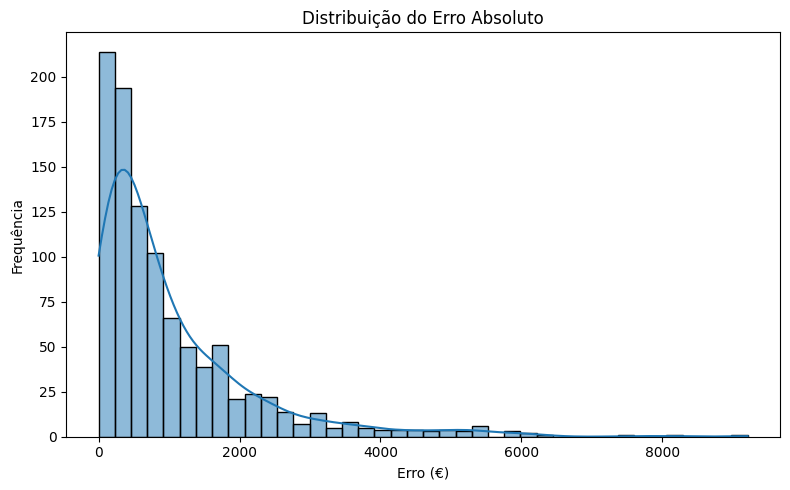

In [47]:
# Gráfico de Erro Absoluto
results_sample['Erro Absoluto'] = abs(results_sample['Preço Real'] - results_sample['Preço Previsto'])
plt.figure(figsize=(8, 5))
sns.histplot(results_sample['Erro Absoluto'], bins=40, kde=True)
plt.title('Distribuição do Erro Absoluto')
plt.xlabel('Erro (€)')
plt.ylabel('Frequência')
plt.tight_layout()
plt.show()

In [48]:
# Estatísticas de erro
erro_medio = results_sample['Erro Absoluto'].mean()
erro_mediana = results_sample['Erro Absoluto'].median()
erro_maximo = results_sample['Erro Absoluto'].max()

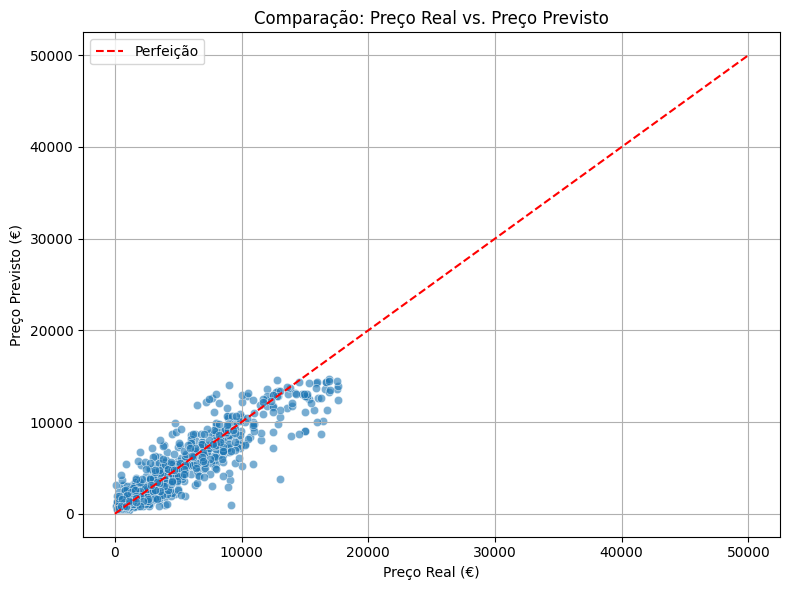

In [49]:
# Gráfico de dispersão: Preço Real vs Preço Previsto
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Preço Real', y='Preço Previsto', data=results_sample, alpha=0.6)
plt.plot([0, 50000], [0, 50000], color='red', linestyle='--', label='Perfeição')
plt.title('Comparação: Preço Real vs. Preço Previsto')
plt.xlabel('Preço Real (€)')
plt.ylabel('Preço Previsto (€)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [51]:
# Conclusão
print("🔍 Conclusão da Análise:")
print(f"- Erro Médio Absoluto (MAE): €{round(mae_score, 2)}")
print(f"- Erro Médio Amostrado: €{round(erro_medio, 2)}")
print(f"- Erro Mediano: €{round(erro_mediana, 2)}")
print(f"- Maior erro encontrado: €{round(erro_maximo, 2)}")
print("\n📌 Interpretação:")
print("O modelo é capaz de prever preços com erro médio em torno de €1.000.")

🔍 Conclusão da Análise:
- Erro Médio Absoluto (MAE): €1035.84
- Erro Médio Amostrado: €1021.35
- Erro Mediano: €625.57
- Maior erro encontrado: €9209.33

📌 Interpretação:
O modelo é capaz de prever preços com erro médio em torno de €1.000.
Apesar de útil para estimativas rápidas, o modelo apresenta limitações para valores extremos.
Recomenda-se aumentar a profundidade do modelo e explorar novos algoritmos para melhores resultados.


Após o primeiro treinamento do modelo de regressão com Random Forest, obtivemos resultados promissores. O Erro Médio Absoluto (MAE) foi de aproximadamente €1035,84, indicando que, em média, o modelo erra em torno de mil euros ao prever o preço de um veículo. Além disso, a mediana dos erros foi ainda menor, em torno de €625,57, sugerindo que mais da metade das previsões possuem um erro inferior a esse valor. A diferença entre a média e a mediana mostra que o modelo tem boa consistência, com poucos casos de erro muito alto — o maior erro registrado foi de aproximadamente €9209,33.

Esses resultados indicam que o modelo está capturando bem a relação entre as variáveis (como ano, quilometragem, marca, tipo de combustível, etc.) e o preço final do carro. A performance é especialmente interessante considerando que utilizamos um modelo simples e sem grande ajuste fino, o que demonstra o potencial da abordagem mesmo em sua versão inicial. O desempenho pode ser ainda mais aprimorado com ajustes adicionais, aumento dos parametros ou feature engineering.

Mesmo sendo a primeira versão do modelo, ele já consegue prever o preço dos carros com boa precisão. Na maioria dos casos, ele erra por menos de mil euros, o que é excelente para quem precisa de uma estimativa rápida e confiável do valor de um veículo.